In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm.notebook as tqdm

In [2]:
#import matplotlib as mpl
#plt.rcParams.update({
#    "text.usetex": True})

In [31]:
def random_cov_matrix(d, alpha=1/3):
    """
    Generate a random covariance matrix according to annexe G1
    """
    k = int(np.round(d/alpha))
    M = np.random.normal(size=(k,d))
    A_tilde = M.T@M
    A = A_tilde / np.trace(A_tilde)
    return A

def random_cov_matrix_k(d, alpha=1/3):
    """
    Generate a random covariance matrix according to annexe G1
    """
    k = int(np.round(d/alpha))
    M = np.random.normal(size=(k,d))
    A_tilde = M.T@M
    A = A_tilde / k
    return A

def mat_sqrt(A):
    u, s, vh = np.linalg.svd(A)
    return (u * np.sqrt(s)) @ vh

def random_uniform_sphere(d, size=1):
    x = np.random.normal(size=(size,d))
    return x / np.linalg.norm(x,axis=-1, keepdims=True)

def random_R(d, alpha, beta, size=1):
    z = np.random.normal(size=size)
    return alpha*np.abs(np.arctan(z/beta))**(1/d)

def estimate_alpha(beta, d, nb_steps=10000):
    R = random_R(d, 1, beta, size=nb_steps)
    return np.sqrt(d) / np.mean(R*R)

def sample_X(d, alpha, beta, A, size=1):
    A_sqrt = mat_sqrt(A)
    R = random_R(d, alpha, beta, size=1)
    U = random_uniform_sphere(d, size=size)
    return (R * U) @ A_sqrt

def log_sum_exp(x, coef):
    max_value = np.max(x, axis=1)
    return max_value + np.log(np.sum(np.exp(x-max_value[:,np.newaxis])*coef,axis=1))

def sinkhorn_step(C, p, q, v, lbda):
    u = -lbda * log_sum_exp((v-C)/lbda, q)
    v = -lbda * log_sum_exp((u-C.T)/lbda, p)
    return u,v

def sinkhorn_algo(mu, nu, lbda, p=None, q=None, nb_steps=10000):
    p = np.ones(len(mu))/len(mu) if p is None else p
    q = np.ones(len(nu))/len(nu) if q is None else q
    diff = mu[:,np.newaxis,:] - nu[np.newaxis, :,:]
    C = 0.5*np.sum(diff*diff, axis=-1)
    v = np.zeros(len(nu), dtype=np.float64)
    for _ in range(nb_steps):
        u,v = sinkhorn_step(C, p, q, v, lbda)
    return u,v

def compute_T(mu, nu, lbda, p=None, q=None):
    p = np.ones(len(mu))/len(mu) if p is None else p
    q = np.ones(len(nu))/len(nu) if q is None else q
    u,v = sinkhorn_algo(mu, nu, lbda, p, q)
    return u@p + v@q

In [32]:
n = 1000
d = 5
A = random_cov_matrix(d)
beta = 1
lbda = 0.000001
alpha = estimate_alpha(beta, d)
mu = sample_X(d, alpha, beta, A, n)
nu = sample_X(d, alpha, beta, A, n)
compute_T(mu, nu, lbda)

KeyboardInterrupt: 

In [ ]:
dist = []
n_values = np.logspace(10, 500, 10, dtype=np.int)
for n in tqdm.tqdm(n_values):
    d = 5
    A = random_cov_matrix(d)
    beta = 1
    lbda = 0.1
    alpha = estimate_alpha(beta, d)
    mu = sample_X(d, alpha, beta, A, n)
    nu = sample_X(d, alpha, beta, A, n)
    dist.append(compute_T(mu, nu))
    
plt.plot(dist)
plt.yscale("log")
plt.xscale("log")

/Users/leoheidelberger/miniconda3/lib/python3.7/site-packages/numpy/core/function_base.py:275: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y).astype(dtype, copy=False)


In [4]:
import unittest

class TestRandom(unittest.TestCase):
    def test_random_cov_matrix(self):
        d = 13 
        A = random_cov_matrix(d)
        self.assertEqual(A.shape, (d,d))
    
    def test_random_uniform_sphere(self):
        x = random_uniform_sphere(13)
        assert np.allclose(np.sum(x*x), 1)
        
    def test_estimate_alpha(self):
        estimate_alpha(1, 13, nb_steps=1000)
    
    def test_sample(self):
        d = 13
        A = random_cov_matrix(d)
        size = 17
        beta = 1
        alpha = estimate_alpha(beta, d)
        x = sample_X(d, alpha, beta, A, size)
        self.assertEqual(x.shape, (size, d))
    def test_mat_sqrt(self):
        d = 13
        A = random_cov_matrix(d)
        S = mat_sqrt(A)
        self.assertTrue(np.allclose(S@S, A))

class TestAlgos(unittest.TestCase):
    def test_sinkhorn(self):
        d = 5
        A = random_cov_matrix(d)
        n = 100
        beta = 1
        lbda = 0.1
        alpha = estimate_alpha(beta, d)
        mu = sample_X(d, alpha, beta, A, n)
        nu = sample_X(d, alpha, beta, A, n-1)
        u,v = sinkhorn_algo(mu, nu, lbda, nb_steps=100)
        p = np.ones(len(mu))/len(mu)
        q = np.ones(len(nu))/len(nu)
        diff = mu[:,np.newaxis,:] - nu[np.newaxis, :,:]
        C = 0.5*np.sum(diff*diff, axis=-1)
        P = p[:,None] * np.exp((u[:,None]+v[None,:]-C)/lbda) * q[None,:]
        self.assertLess(np.linalg.norm((np.sum(P,1)-p), 1), 1e-3)

        
unittest.main(argv=[''], verbosity=2, exit=False)

test_sinkhorn (__main__.TestAlgos) ... ok
test_estimate_alpha (__main__.TestRandom) ... ok
test_mat_sqrt (__main__.TestRandom) ... ok
test_random_cov_matrix (__main__.TestRandom) ... ok
test_random_uniform_sphere (__main__.TestRandom) ... ok
test_sample (__main__.TestRandom) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.058s

OK


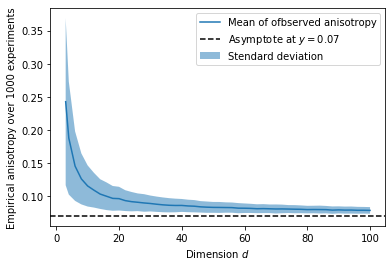

In [7]:
def plot_random_cov_matrix_eigenvalues(min_d=3, max_d=100, nb_points=50, exp_per_points=1000):    
    dimensions = np.linspace(min_d, max_d, nb_points, dtype=np.int)
    mean = []
    std = []
    for d in tqdm.tqdm(dimensions):
        res = []
        for _ in range(exp_per_points):
            A = random_cov_matrix(d)
            #Min eigenvalue / Max eigenvalue
            ratio = np.linalg.cond(A, p=-2)
            res.append(ratio)
        mean.append(np.mean(res))
        std.append(np.std(res))
    mean = np.array(mean)
    std = np.array(std)
    plt.plot(dimensions, mean, label="Mean of ofbserved anisotropy")
    plt.axhline(y=0.07, color="black", linestyle="--", label="Asymptote at $y = 0.07$")
    plt.fill_between(dimensions, mean-std, mean+std, alpha=0.5, label="Stendard deviation")
    plt.ylabel(f"Empirical anisotropy over {exp_per_points} experiments")
    plt.xlabel("Dimension $d$")
    plt.legend()
    plt.savefig("images/anisotropy.svg")
    plt.savefig("images/anisotropy.png")
            
plot_random_cov_matrix_eigenvalues()

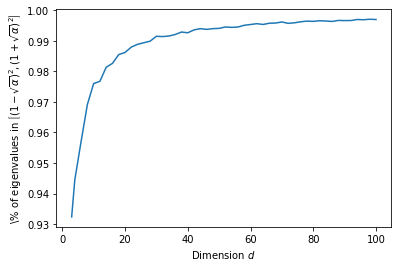

In [8]:
def plot_random_cov_matrix_eigenvalues(min_d=3, max_d=100, nb_points=50, exp_per_points=1000, alpha = 1/3):    
    dimensions = np.linspace(min_d, max_d, nb_points, dtype=np.int)
    mean = []
    std = []
    int_min = (1 - np.sqrt(alpha))**2
    int_max = (1 + np.sqrt(alpha))**2
    for d in tqdm.tqdm(dimensions):
        res = []
        for _ in range(exp_per_points):
            k = int(np.round(d/alpha))
            M = np.random.normal(size=(k,d))
            A = M.T@M
            A = A / k
            eigs = np.linalg.eigvals(A)
            count = np.sum((int_min < eigs) & (eigs < int_max))
            res.append(count/d)
        mean.append(np.mean(res))
        #mean.append(np.mean(eigs))
        std.append(np.std(res))
    mean = np.array(mean)
    std = np.array(std)
    plt.plot(dimensions, mean)
    plt.ylabel("\% of eigenvalues in $\\left [ (1 - \\sqrt{\\alpha})^2,  (1 + \\sqrt{\\alpha})^2  \\right]$")
    plt.xlabel("Dimension $d$")
    plt.savefig("images/within_int.svg")
    plt.savefig("images/within_int.png")
            
plot_random_cov_matrix_eigenvalues()